In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap


c:\Users\Ismae\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_pickle("dataset.pkl")

In [3]:
dataset.columns

Index(['id', 'name', 'move_type', 'payment_state', 'company_id', 'partner_id',
       'currency_id', 'invoice_date', 'invoice_date_due', 'payment_dates',
       'company_name', 'partner_name', 'currency_name', 'amount_total_eur',
       'amount_residual_eur', 'payment_overdue_days',
       'payment_overdue_category', 'term', 'term_rounded', 'term_mapped',
       'term_encoded', 'delay_encoded', 'avg_invoiced_prior',
       'num_prior_invoices', 'num_late_prior_invoices',
       'ratio_late_prior_invoices', 'total_invoice_amount_prior',
       'total_invoice_amount_late_prior', 'ratio_invoice_amount_late_prior',
       'avg_delay_prior_late_invoices', 'avg_delay_prior_all',
       'num_outstanding_invoices', 'num_outstanding_invoices_late',
       'ratio_outstanding_invoices_late', 'total_invoice_amount_outstanding',
       'total_invoice_amount_outstanding_late',
       'ratio_invoice_amount_outstanding_late',
       'avg_payment_term_prior_invoices', 'due_last_three_days_month',
     

## Baseline

In [4]:
y = dataset['payment_overdue_category'].copy()
X = dataset[['amount_total_eur', 'term_rounded', 'currency_name', 'company_name', 'partner_name', 'due_last_three_days_month', 'due_date_second_half_month']].copy()

In [5]:
X['due_last_three_days_month'] = X['due_last_three_days_month'].astype(int)
X['due_date_second_half_month'] = X['due_date_second_half_month'].astype(int)


In [6]:
# Encoding por frecuencias para partner_name dada la gran cantidad de clientes
freq = X['partner_name'].value_counts()
X['partner_freq'] = X['partner_name'].map(freq)
X = X.drop('partner_name', axis=1)

In [7]:
# One-hot encoding para las demás variables categóricas
categorical_cols = ['currency_name', 'company_name']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough' 
)

In [8]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1-15       0.56      0.56      0.56       530
       16-30       0.35      0.33      0.34       166
       31-60       0.38      0.40      0.39       189
         >60       0.36      0.39      0.37       174
     Puntual       0.78      0.76      0.77      1001

    accuracy                           0.61      2060
   macro avg       0.48      0.49      0.48      2060
weighted avg       0.61      0.61      0.61      2060



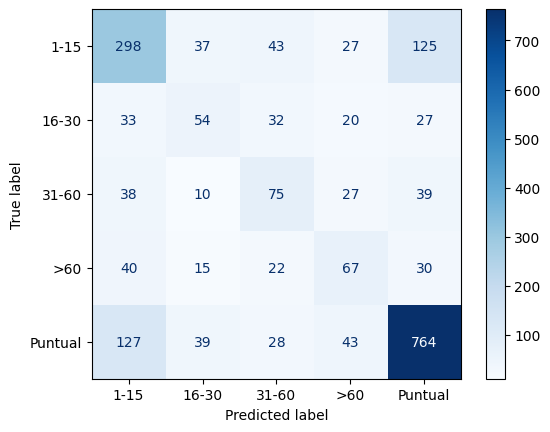

In [11]:
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,
                              display_labels=model_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)

Orden de las clases en el modelo:
['1-15' '16-30' '31-60' '>60' 'Puntual']


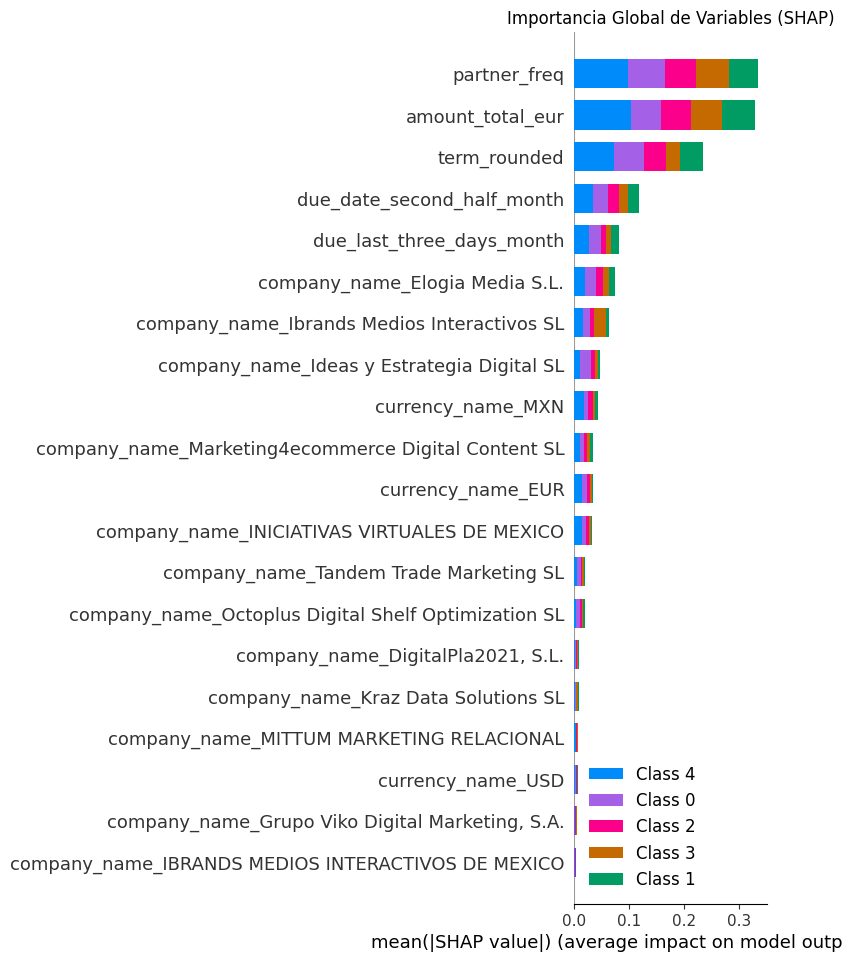

In [22]:

X_test_sample = X_test.sample(n=100, random_state=42)
preprocessor = model_pipeline.named_steps['preprocessor']
rf_model = model_pipeline.named_steps['classifier']

X_test_transformed = preprocessor.transform(X_test_sample)
categorical_features = ['currency_name', 'company_name']
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

numeric_features = [col for col in X_test_sample.columns if col not in categorical_features]
feature_names = list(ohe_feature_names) + numeric_features


explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed)

print("Orden de las clases en el modelo:")
print(rf_model.classes_)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Importancia Global de Variables (SHAP)")
plt.show()

El modelo baseline sin utilizar un split temporal y sin histórico del cliente consigue un accuracy del 61%, este modelo tiene en cuenta "quién es el cliente" y "cuánto es la factura?" principalmente, este valor de accuracy no es fiable dada el desbalanceo que hay entre clases. Las puntuales lo hace bastante bien con un 76% de F1-score, 1-15 con un 50% pero despues 16-30, 31-60 y más de 60 lo hace mal con un 34%-40%.

## Modelo 2

In [19]:
shap.plots.text(shap_values)

AttributeError: 'numpy.ndarray' object has no attribute 'values'